# 1.0 Basic Observation about the data

- 1.1 Data types, shape, sample & Completeness of Data
- 1.2 Null and duplicate rows
- 1.3 Dropping non useful columns for modeling & analysis

In [1]:
# imoport libraries
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

# set column and row display lengths in jupyter
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# Supressing the warning messages
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score, make_scorer, precision_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from mlxtend.classifier import StackingClassifier

In [2]:
# read excel
df = pd.read_excel('Tourism.xlsx', sheet_name='Tourism')

In [3]:
# check a sample of the data
df.sample(6)

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
3947,203947,1,40.0,Self Enquiry,3,12.0,Large Business,Male,3,4.0,Deluxe,3.0,Married,5.0,0,1,0,1.0,Manager,20764.0
484,200484,0,31.0,Self Enquiry,3,12.0,Small Business,Male,3,2.0,Deluxe,3.0,Married,5.0,0,5,1,2.0,Manager,20460.0
1053,201053,0,57.0,Self Enquiry,1,6.0,Salaried,Male,3,1.0,Deluxe,3.0,Divorced,1.0,0,3,1,2.0,Manager,19900.0
2604,202604,0,23.0,Self Enquiry,1,26.0,Small Business,Male,4,4.0,Basic,3.0,Divorced,3.0,0,2,0,2.0,Executive,21001.0
1358,201358,0,31.0,Self Enquiry,3,16.0,Small Business,Female,2,3.0,Deluxe,3.0,Married,3.0,1,1,0,0.0,Manager,21583.0
1791,201791,0,31.0,Self Enquiry,3,13.0,Small Business,Male,3,3.0,Deluxe,3.0,Married,5.0,0,1,0,0.0,Manager,22547.0


In [4]:
# print df.shape, df.info() and how many categorical columns in particular
obj_cols = df.select_dtypes(include = ['object', 'category']).columns.to_list()
print(f' the shape of the data is {df.shape} and no of non-numerical cols is: {len(obj_cols)} '); print('*'*50)
df.info()

 the shape of the data is (4888, 20) and no of non-numerical cols is: 6 
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64

In [5]:
# drop CustomerID, since it doesn't add any value for our analysis
df.drop(['CustomerID'], axis = 1, inplace = True)

In [6]:
# function for total count of missing values as well as percentage of missing values 

def missing_values(df):
    missing = df.isna().sum()
    percent_missing = round(df.isna().mean()*100,2) 
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'missing': missing,
                                 'percent_missing': percent_missing}).reset_index(drop = True)
    return missing_value_df


# function for printing value counts (incl NaN) for categorical columns
def get_value_counts(df):
    obj_cols = df.select_dtypes(include = ['object', 'category']).columns.to_list()
    for idx, col in enumerate(obj_cols):
        print(df[col].value_counts(dropna = False))
        print('*'*25)


In [7]:
# check the missing values in columns along with percentage
missing_values(df)

,column_name,missing,percent_missing
0,ProdTaken,0,0.00
1,Age,226,4.62
2,TypeofContact,25,0.51
3,CityTier,0,0.00
4,DurationOfPitch,251,5.14
5,Occupation,0,0.00
6,Gender,0,0.00
7,NumberOfPersonVisiting,0,0.00
8,NumberOfFollowups,45,0.92
9,ProductPitched,0,0.00


In [8]:
get_value_counts(df) # for categorical variables

Self Enquiry       3444
Company Invited    1419
NaN                  25
Name: TypeofContact, dtype: int64
*************************
Salaried          2368
Small Business    2084
Large Business     434
Free Lancer          2
Name: Occupation, dtype: int64
*************************
Male       2916
Female     1817
Fe Male     155
Name: Gender, dtype: int64
*************************
Basic           1842
Deluxe          1732
Standard         742
Super Deluxe     342
King             230
Name: ProductPitched, dtype: int64
*************************
Married      2340
Divorced      950
Single        916
Unmarried     682
Name: MaritalStatus, dtype: int64
*************************
Executive         1842
Manager           1732
Senior Manager     742
AVP                342
VP                 230
Name: Designation, dtype: int64
*************************


In [9]:
# let's deal with typo in Gender right away and convert 'Fe Male' to 'Female' in Gender
df.loc[df.Gender =='Fe Male', 'Gender'] = 'Female'

In [10]:
# check that Gender column is now right
df['Gender'].value_counts(dropna = False)

Male      2916
Female    1972
Name: Gender, dtype: int64

In [11]:
# lets check the duplicated rows now
print(f'No of duplicated rows {df.duplicated().sum()}')

No of duplicated rows 141


In [12]:
# lets delete those duplicated rows as well
df.drop_duplicates(inplace = True)

## General Observation about the data

- Many missing (null) values 
- total 20 columns, 6 non-numerical columns
- there were 141 duplicated rows (which were fixed)

# 2.0 Exploratory Data Analysis (EDA)

- 2.1 Univariate and bivariate analysis
- 2.2 Insights based on EDA

In [13]:
# Lets first start with the dependent variable and check the percentage of classes
df['ProdTaken'].value_counts(normalize = True)

0    0.811671
1    0.188329
Name: ProdTaken, dtype: float64

In [14]:
# now let's run a 5 point summary of numerical cols
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ProdTaken,4747.0,0.188329,0.391016,0.0,0.0,0.0,0.0,1.0
Age,4531.0,37.585522,9.328723,18.0,31.0,36.0,44.0,61.0
CityTier,4747.0,1.655151,0.917416,1.0,1.0,1.0,3.0,3.0
DurationOfPitch,4501.0,15.510998,8.535634,5.0,9.0,13.0,20.0,127.0
NumberOfPersonVisiting,4747.0,2.911734,0.724040,1.0,2.0,3.0,3.0,5.0
NumberOfFollowups,4703.0,3.705082,1.008677,1.0,3.0,4.0,4.0,6.0
PreferredPropertyStar,4721.0,3.583351,0.800351,3.0,3.0,3.0,4.0,5.0
NumberOfTrips,4609.0,3.233239,1.847851,1.0,2.0,3.0,4.0,22.0
Passport,4747.0,0.289657,0.453651,0.0,0.0,0.0,1.0,1.0
PitchSatisfactionScore,4747.0,3.051612,1.369584,1.0,2.0,3.0,4.0,5.0


## Insights from 5 point Summary (descriptive staistics)
- the dependent variable, ProdTaken, is highly imbalanced with 18.8% of values as 1, and 81.1% values as 0
- Median Age of customers is 36, while 50 % (between 1st and 3rd quartile) of the customers fall into 31 - 44 yrs
- Most of the customers belong to Tier 1
- Duration of pitch is right skewed, with some visible outliers
- Most of the customers have NumberofPersonVisiting 3 
- 4 is the highest Noofollowps seen from the data
- 3 star dominates in Customer's PreferredPropertyStar
- Most of the customers have no passport
- 3 is the highest PitchSatisfactionScore seen from the data
- Most of the customers own car
- Most of the customers have NumberofChildrenVisiting as as 1
- MonthlyIncome is right skewed, with visible outliers
    - also scale could be a concren here since the vales are in tens of thousands to hundreds of thousands while other variables hardly reach in hundreds
    - we may have to consider applying scaling


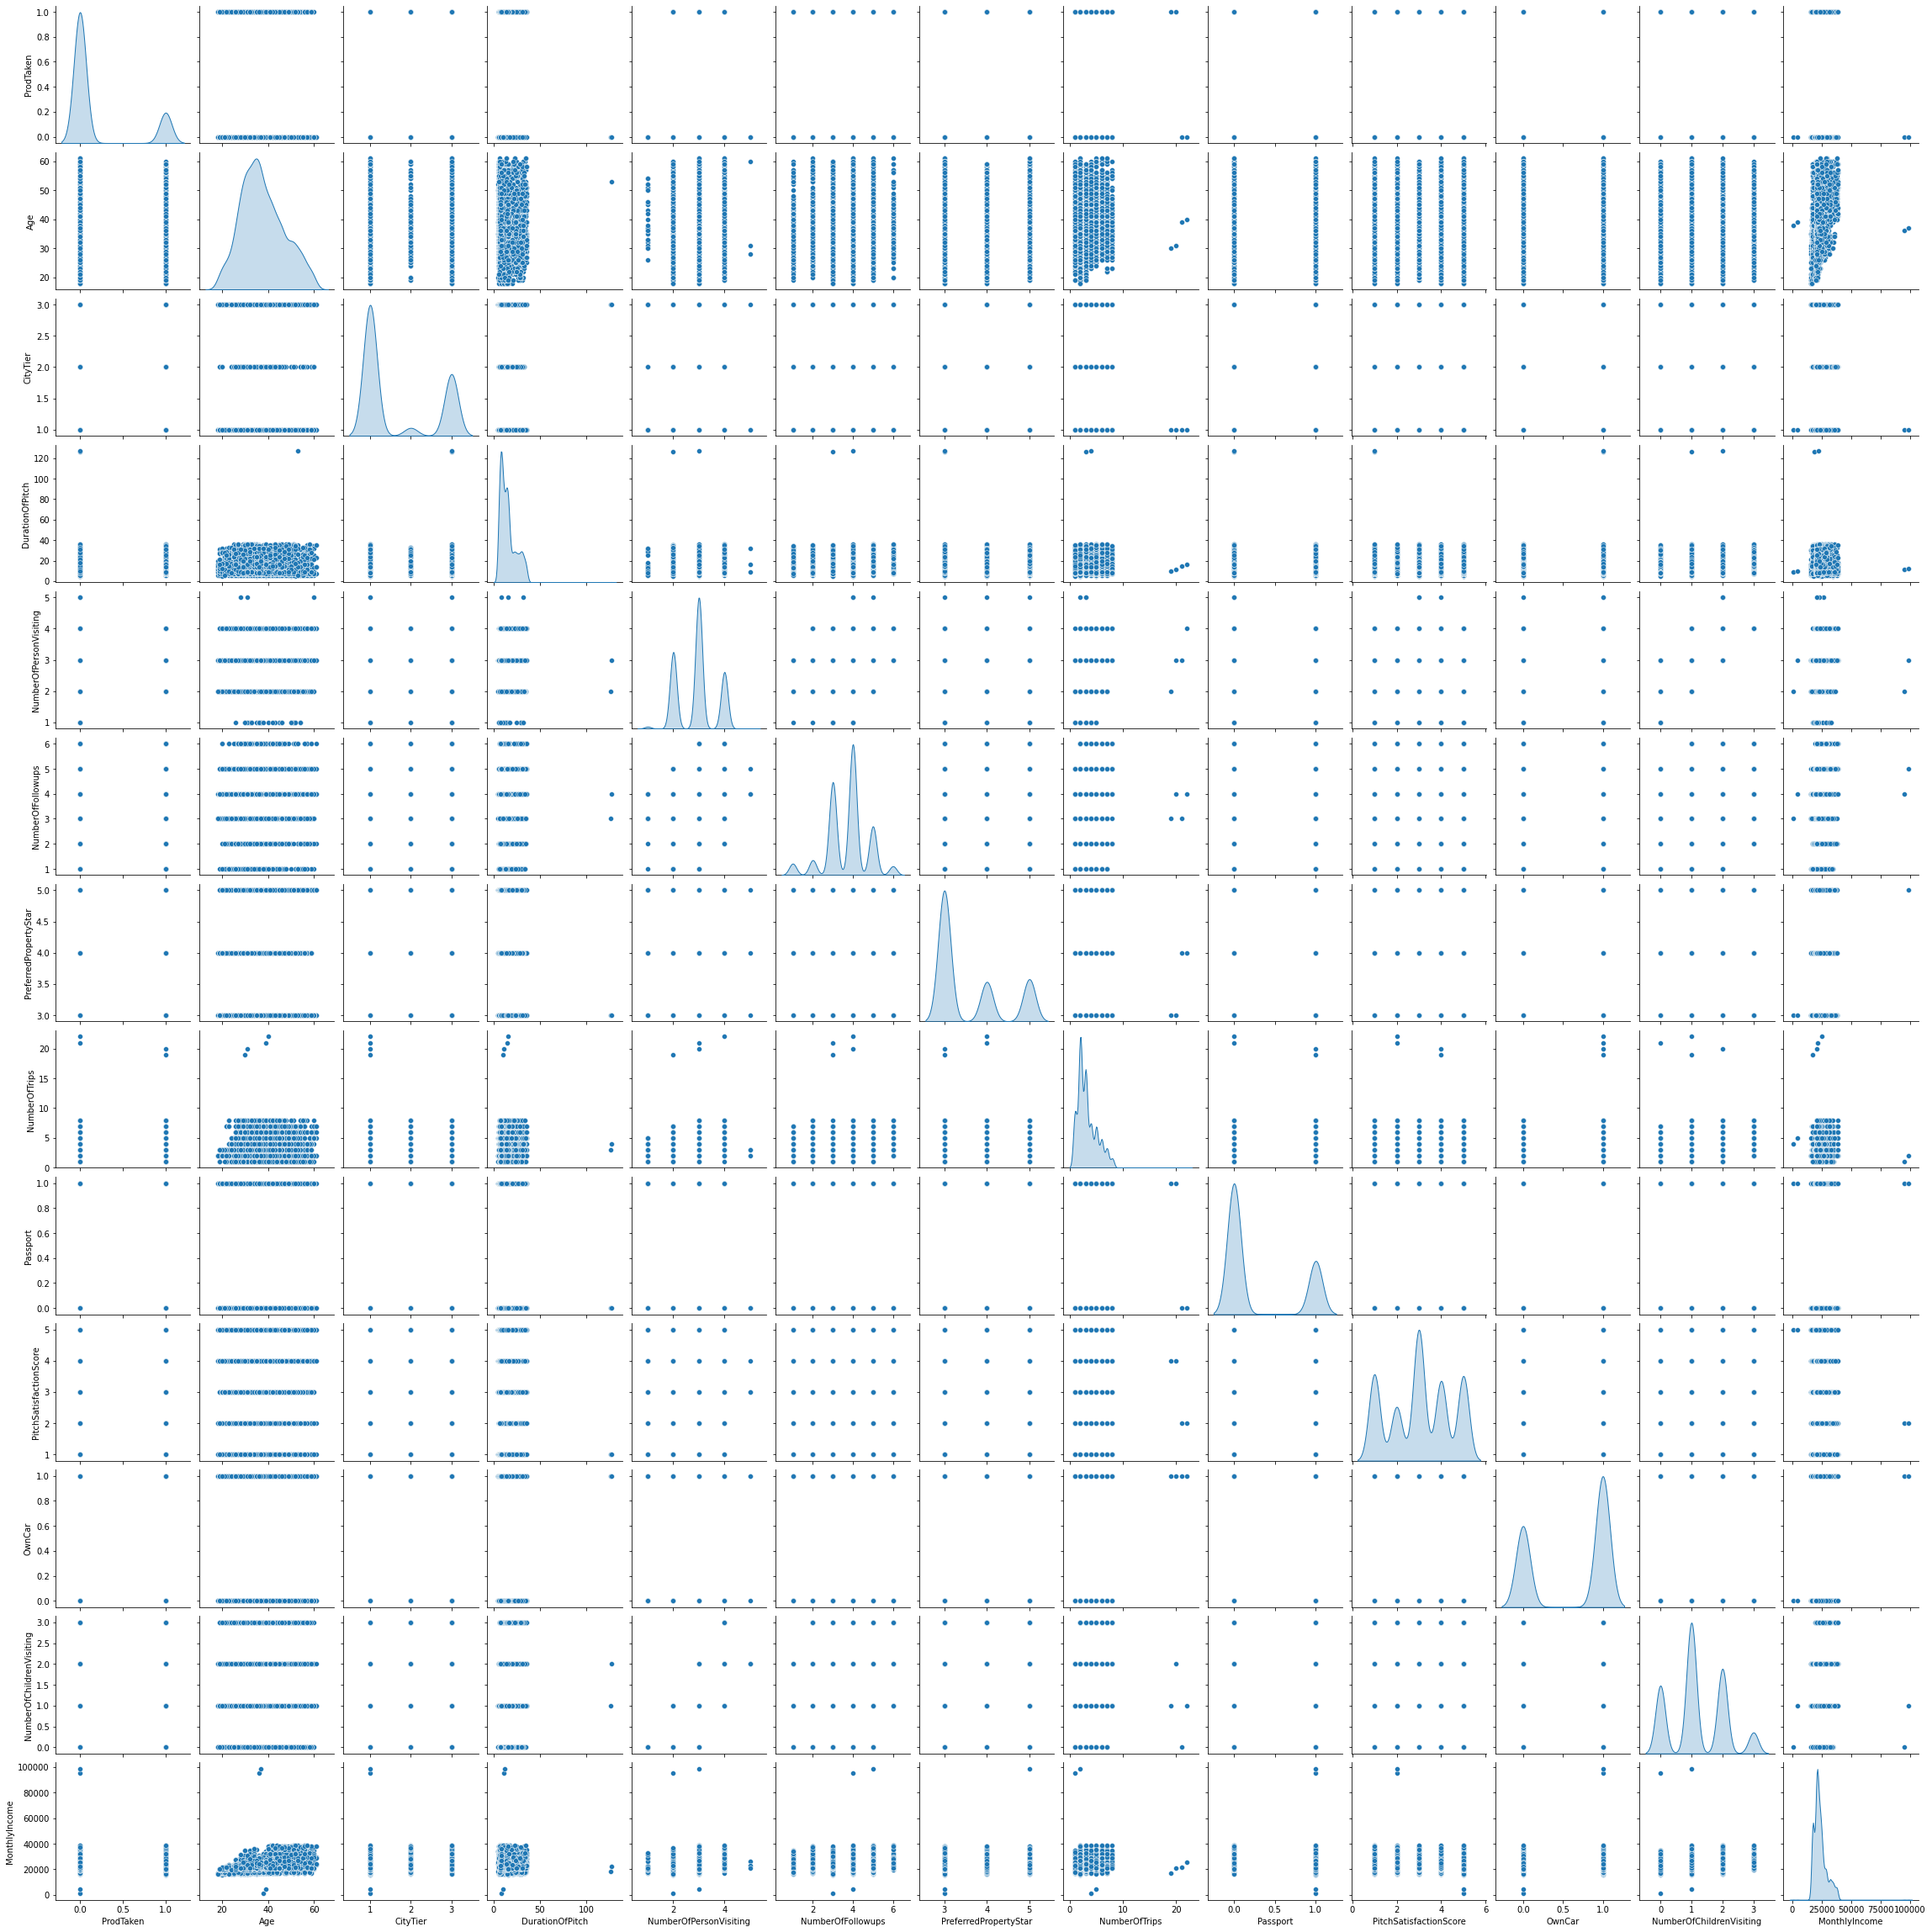

In [15]:
# Now let's quickly check the pair plot for univariate distribution & bivariate relationship
sns.pairplot(df, diag_kind = 'kde')

Observation from pairplot
- pairplotplot doesn't explain too much since there are just too many variables. We should check histograms of only fewselected variables
- Still from the pairplot, we can observe that Age, MonthlyIncome, DurationofPitch are found to be noramally distributed
- Many variables are seen to have several peaks, probably hinting that they take only few discrete values


<AxesSubplot:>

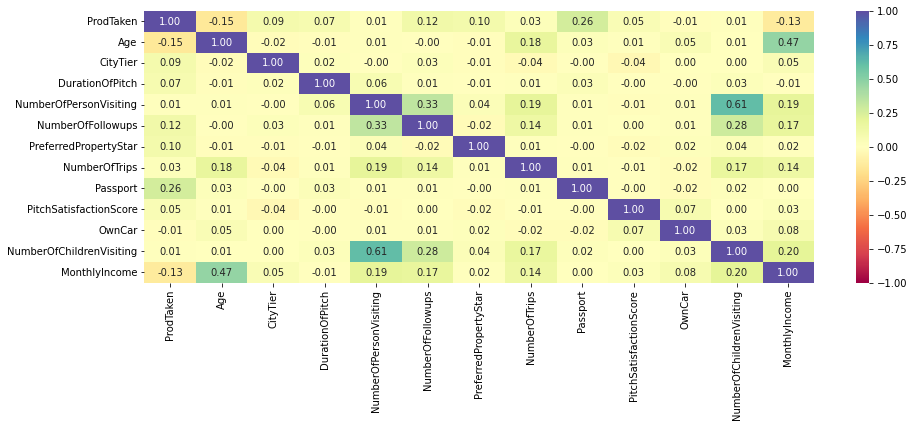

In [16]:
# and let's plot correlation plot (heatmap) to check linear correlation, if any between variables
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(df.corr(), annot = True, fmt = ".2f", vmin = -1, vmax = 1, cmap = "Spectral")

Observation from correlation plot (heatmap)
- there isn't too much case of multi-collinearity seen here
- Age and income are somewhat linearly correlated (0.47)
- NumberofPersonsVisiting and NumberofChildrenVisiting are correlated (0.61 - as expected)
- but we'll not do anything for the above multi-collinearity cases, since our model will be all Tree based

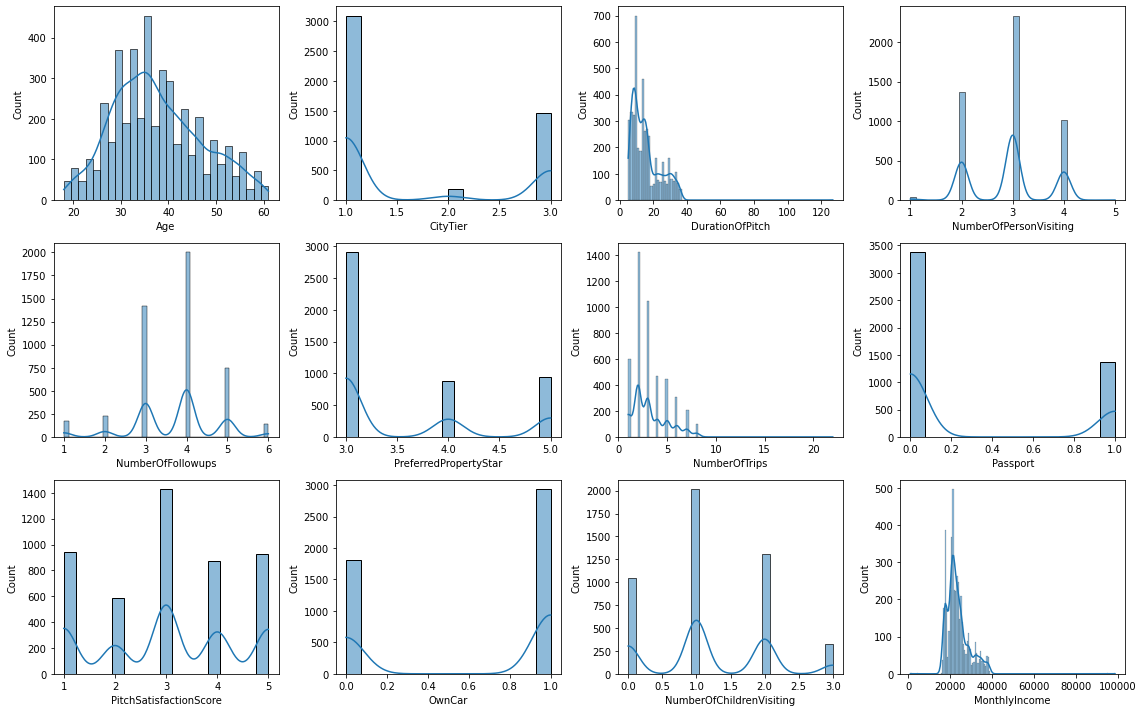

In [17]:
# Now plot the histograms of numerical variables
numeric_only = df.select_dtypes(include=np.number).columns.tolist()
numeric_only.remove('ProdTaken')
# remove the dependent variable, ProdTaken, from the above list

# setting the number of columns and rows of figure
ncols = 4; nrows = 3

# setting figure size and axes
fig, ax = plt.subplots(ncols = ncols, nrows =nrows, figsize = (16,10))

for ind, x in enumerate(numeric_only):
        i = ind//ncols; j = ind%ncols
        sns.histplot(x = x, data = df, kde = True, ax = ax[i,j] )

        
plt.tight_layout()
plt.show()

Observations from Histograms
- Nothing special. We already observed those in 5 point Summary

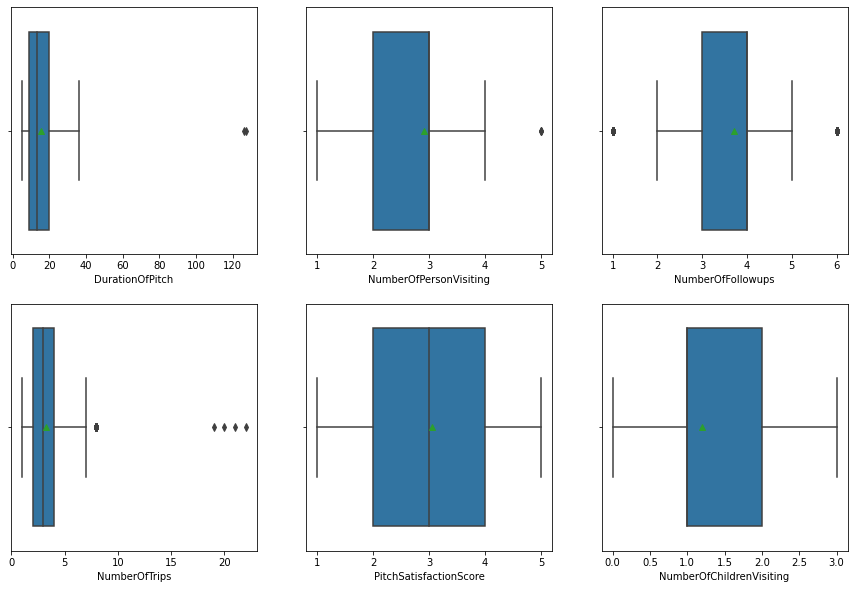

In [18]:
# Lets plot Boxplots for some numerical cols having mostly dicrete values
# setting the figure size and axes
box_cols = ['DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups',  
'NumberOfTrips', 'PitchSatisfactionScore','NumberOfChildrenVisiting'      ]

ncols = 3; nrows = 2
fig, ax = plt.subplots(ncols = ncols, nrows =nrows, figsize = (15,10))

for ind, x in enumerate(box_cols):
        i = ind//ncols; j = ind%ncols
        sns.boxplot(x = x, data = df, showmeans = True, ax = ax[i,j])

plt.show()

Observations

- Nothing special. We already observed those in 5 point Summary

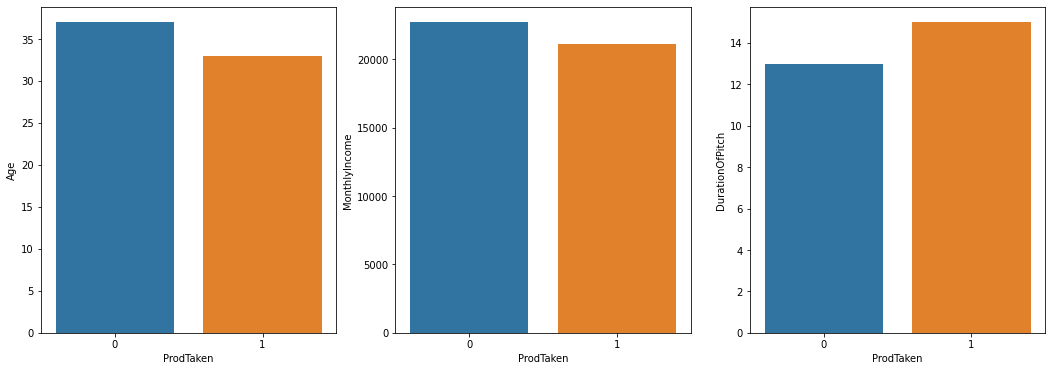

In [19]:
# Let's now compare how ProdTaken is affected by real numerical (non-discrete) variables
oth_col = ['Age', 'MonthlyIncome', 'DurationOfPitch']
#setting the figure size and axes
fig, ax = plt.subplots(1,3, figsize = (18,6))

x = 'ProdTaken'
for ind, y in enumerate(oth_col):
        sns.barplot(x = x, y = y ,data = df ,estimator = np.median, ci = None, ax = ax[ind])
        # using estimator as median 


Observation

- For customers who have taken the Prouct, (ProdTaken = 1), median age, and median MonthlyIncome is lower than those customers who have not taken any Product (ProdTaken = 0)
- Also, DurationofPitch is longer for customers who have taken the Prouct, (ProdTaken = 1)

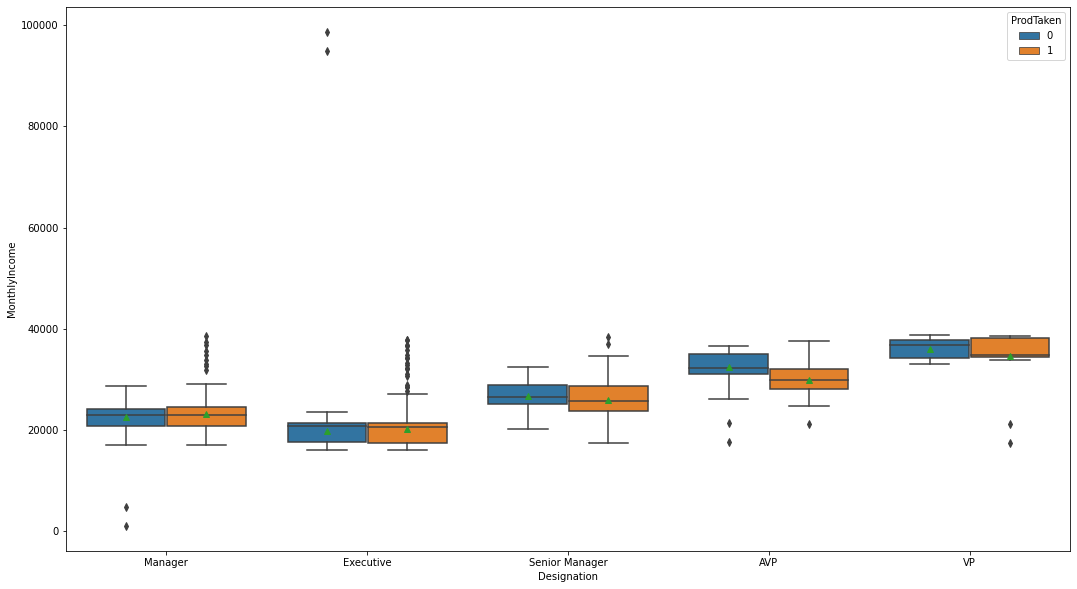

In [20]:
# let's check how Designation and MonthlyIncome affects ProdTaken
fig, ax = plt.subplots(ncols = 1, nrows =1, figsize = (18,10))
sns.boxplot(x = 'Designation', y = 'MonthlyIncome', data = df, showmeans = True, hue = 'ProdTaken')
plt.show()

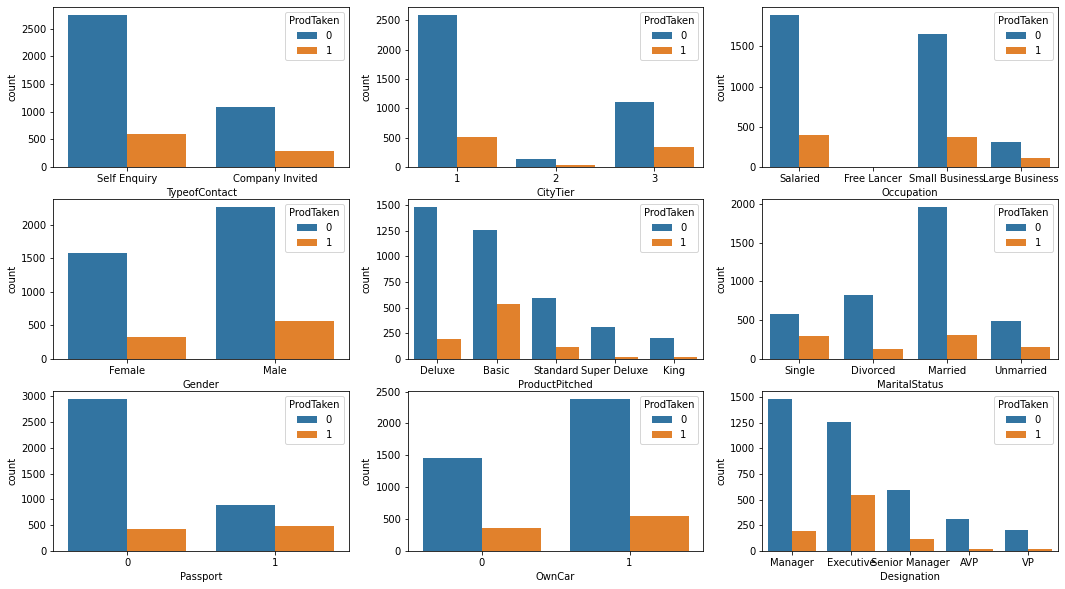

In [21]:

# lets check how other categorical and some numerical variables with only few discrte values (for eg Passport, OwnCar)
# affects ProdTaken
cust_profile = ['TypeofContact','CityTier','Occupation','Gender','ProductPitched',
'MaritalStatus','Passport','OwnCar','Designation']

ncols = 3; nrows =3 ; hue = 'ProdTaken'
# setting the figure size and axes
fig, ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = (18,10))

for ind, x in enumerate(cust_profile):
        i = ind//ncols; j = ind%ncols
        sns.countplot(x = x, hue = hue,  data = df, ax = ax[i,j])


plt.show()

# Observation 
- Self Enquiry leads when it comes to customers who have taken Product(ProdTaken = 1)
- Tier 1 city is the leading CityTier
- Male have taken more products than Female
- More customers who own car have taken Product
- More customes whose Designation is Executive have taken the Product
- the relationship shown by ProductPitched and Designation w.r.t ProdTaken is similar
    - we should study if both presents similar kind of data, could we remove one!

In [22]:
# let's check ProductPitched an Designation, grouped by ProdTaken
print(df.groupby(['ProductPitched', 'ProdTaken'])['ProdTaken'].count())
print('*'*50)
df.groupby(['Designation','ProdTaken'])['ProdTaken'].count()

ProductPitched  ProdTaken
Basic           0            1260
                1             540
Deluxe          0            1486
                1             198
King            0             205
                1              20
Standard        0             594
                1             120
Super Deluxe    0             308
                1              16
Name: ProdTaken, dtype: int64
**************************************************


Designation     ProdTaken
AVP             0             308
                1              16
Executive       0            1260
                1             540
Manager         0            1486
                1             198
Senior Manager  0             594
                1             120
VP              0             205
                1              20
Name: ProdTaken, dtype: int64

# Observation
- As far as data content is concerned w.r.t the target, we can see that there isn't any differnce betwen ProductPitched & Designation 
 ProductPitched and Designation are two variables containing similar data, although with different categories

- for e.g. Basic is exactly mapped with Executive, Deluxe is exactly mapped with Manager, King is exactly mapped with VP, Standard is exactly mapped with Senior Manager
, Super Deluxe is exactly mapped with AVP

- there is no need to keep both columns for analysis
- During data pre-processing we shall remove one column



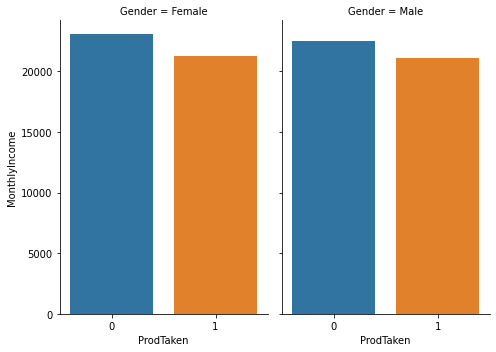

In [23]:
# lets continue checking other variables w.r.t the dependent variables
sns.catplot(x="ProdTaken", y = 'MonthlyIncome', 
            col="Gender", aspect=.7,
            kind="bar", ci = None, estimator = np.median, data=df)

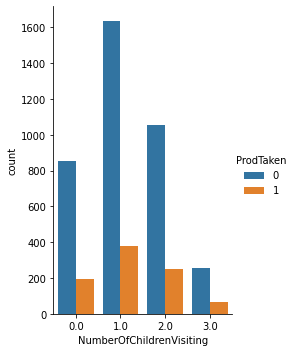

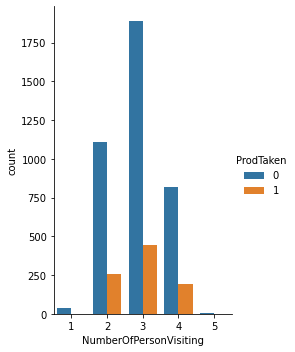

In [24]:
sns.catplot(x="NumberOfChildrenVisiting", hue = 'ProdTaken', 
            aspect=.7,
            kind="count",  data=df, ax = ax[0])

sns.catplot(x="NumberOfPersonVisiting", hue = 'ProdTaken', 
            aspect=.7,
            kind="count",  data=df, ax = ax[1])

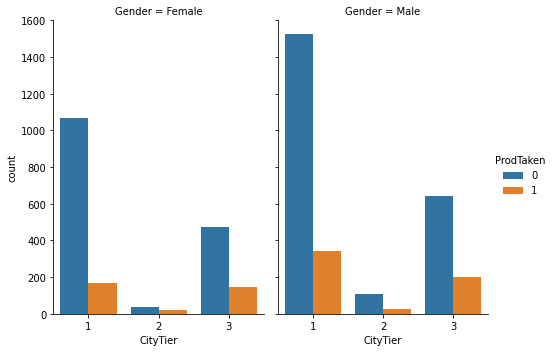

In [25]:
sns.catplot(x="CityTier", hue="ProdTaken",
            col="Gender", aspect=.7,
            kind="count", data=df)

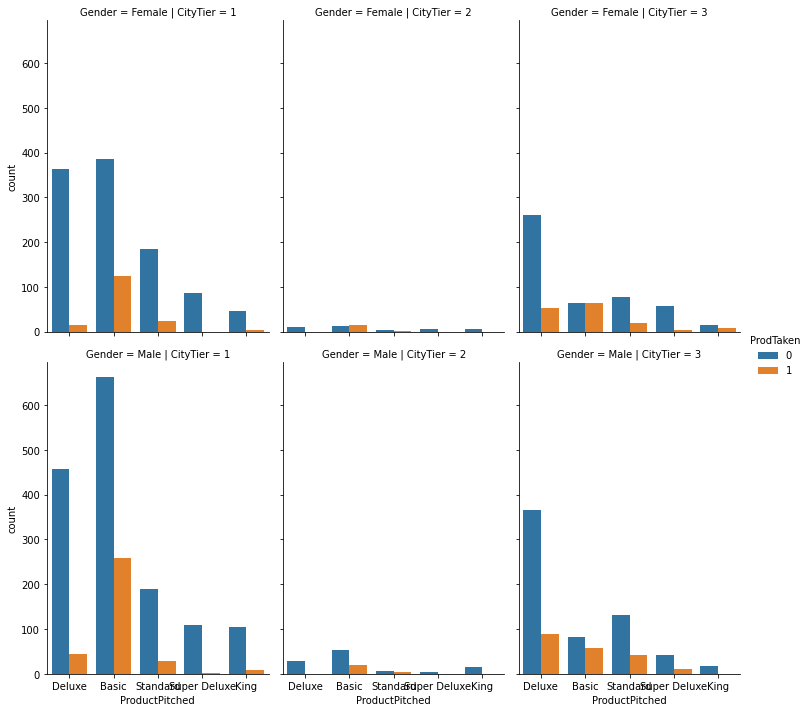

In [26]:
sns.catplot(x="ProductPitched", hue = 'ProdTaken',
            col="CityTier", aspect=.7,
            row = 'Gender',
            kind="count",  data=df)

# Insights from EDA (Customer / Product Profile)
- For customers who have taken the Product, (ProdTaken = 1), median age, and median MonthlyIncome is lower than those customers who have not taken any Product (ProdTaken = 0)
    - this somewhat relates that the Product is attractive to lower echelon of salaried people, or younger people, or both
- Also, DurationofPitch is longer for customers who have taken the Product, (ProdTaken = 1)
- Self Enquiry is the preferred TypeofContact for customers who have taken the Product
- Male leads as customers who who have taken the Product 
- Tier 1 city is the leading CityTier
- More customers who own car have taken Product
- More customes whose Designation is Executive have taken the Product

# 3.0 Data Pre-Processing & Feature Engineering
- 3.1 Missing Values Imputation Strategy
- 3.2 Feature Engineering
        -3.2.1 Rescaling (correcting scales)
        -3.2.1 Ordinality and Label Encoding
        -3.2.3 Data Preparation - One hot encoding & Train/ Test Split

In [27]:
# lets quickly check missing values once again
missing_values(df)

,column_name,missing,percent_missing
0,ProdTaken,0,0.00
1,Age,216,4.55
2,TypeofContact,25,0.53
3,CityTier,0,0.00
4,DurationOfPitch,246,5.18
5,Occupation,0,0.00
6,Gender,0,0.00
7,NumberOfPersonVisiting,0,0.00
8,NumberOfFollowups,44,0.93
9,ProductPitched,0,0.00


## 3.1 Missing Value Imputation Strategy

We shall follow the following Imputation Strategy

- 1. Impute Age Grouped by Gender and imputing the null by median value
        - take the floor when median comes out to be non whole number (Age should be whole number)
- 2. Impute TypeofContact, set NaN to 'Unknown'
- 3. Impute MonthlyIncome, grouped by Designation & Gender and imputing the missing by the median value
- 4. Impute missing values in DurationofPitch with mean
- 5. Impute missing values in ['NumberOfFollowups', 'NumberOfTrips', 'NumberOfChildrenVisiting', 'PreferredPropertyStar'] with median values
        - since these are numbers which should only have whole numbers
        - we will take ceiling values here since 3.2, 3.3 Followups or Trips should be considered 4 for completion

## Additional Note on Outliers
- DurationpofPitch and MonthlyIncome have outliers, but we shall not remove them since we're going to use Tree based models

In [28]:
# impute Age. Grouped by Gender and imputing the null by median value
# Also take the floor when median comes out to be non whole number (Age should be whole number and values like 1.1, 1.2 should be floored to Age 1 )
df['Age'] = df.groupby(['Gender'])['Age'].apply(lambda x: x.fillna(math.floor(x.median())))

In [29]:
# deal with missing value in TypeofContact, impute NaN to Other
df.loc[df.TypeofContact.isna(), 'TypeofContact'] = 'Unknown'

In [30]:
# impute MonthlyIncome, grouped by Designation & Gender and imputing the missing by the median value
df['MonthlyIncome'] = df.groupby(['Designation','Gender'])['MonthlyIncome'].apply(lambda x: x.fillna(x.median()))

In [31]:
missing_values(df)

,column_name,missing,percent_missing
0,ProdTaken,0,0.00
1,Age,0,0.00
2,TypeofContact,0,0.00
3,CityTier,0,0.00
4,DurationOfPitch,246,5.18
5,Occupation,0,0.00
6,Gender,0,0.00
7,NumberOfPersonVisiting,0,0.00
8,NumberOfFollowups,44,0.93
9,ProductPitched,0,0.00


In [32]:
# Imputing missing values in DurationofPitch with mean
df.loc[df.DurationOfPitch.isna(), 'DurationOfPitch'] = df.DurationOfPitch.mean()
missing_values(df)

,column_name,missing,percent_missing
0,ProdTaken,0,0.00
1,Age,0,0.00
2,TypeofContact,0,0.00
3,CityTier,0,0.00
4,DurationOfPitch,0,0.00
5,Occupation,0,0.00
6,Gender,0,0.00
7,NumberOfPersonVisiting,0,0.00
8,NumberOfFollowups,44,0.93
9,ProductPitched,0,0.00


In [33]:
num_c = ['NumberOfFollowups', 'NumberOfTrips', 'NumberOfChildrenVisiting', 'PreferredPropertyStar']
for n in num_c:
    df.loc[df[n].isna(), n] = math.ceil(df[n].median())
    # since these are numbers which should only have whole numbers
    # we've taken ceiling values here since 3.2, 3.3 Followups or Trips should be considered 4 for completion

In [34]:
missing_values(df)

,column_name,missing,percent_missing
0,ProdTaken,0,0.0
1,Age,0,0.0
2,TypeofContact,0,0.0
3,CityTier,0,0.0
4,DurationOfPitch,0,0.0
5,Occupation,0,0.0
6,Gender,0,0.0
7,NumberOfPersonVisiting,0,0.0
8,NumberOfFollowups,0,0.0
9,ProductPitched,0,0.0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4747 entries, 0 to 4887
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProdTaken                 4747 non-null   int64  
 1   Age                       4747 non-null   float64
 2   TypeofContact             4747 non-null   object 
 3   CityTier                  4747 non-null   int64  
 4   DurationOfPitch           4747 non-null   float64
 5   Occupation                4747 non-null   object 
 6   Gender                    4747 non-null   object 
 7   NumberOfPersonVisiting    4747 non-null   int64  
 8   NumberOfFollowups         4747 non-null   float64
 9   ProductPitched            4747 non-null   object 
 10  PreferredPropertyStar     4747 non-null   float64
 11  MaritalStatus             4747 non-null   object 
 12  NumberOfTrips             4747 non-null   float64
 13  Passport                  4747 non-null   int64  
 14  PitchSat

## 3.2 Feature Engineering

In [36]:
# reversing the ordinality of CityTier variable
# In the case, Tier 1 > Tier 2 > Tier 3
# so changing the order so that correct ordinality is ensured
# converting [1 to 7- 1 = 6], [2 to 7-2 = 5], [3 to 7 -3 = 4] so that the ordinality in column matches with case ordinality
df['CityTier']= 7- df['CityTier']

In [37]:
# check that CityTier is now updated
df['CityTier'].value_counts()

6    3098
4    1461
5     188
Name: CityTier, dtype: int64

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4747 entries, 0 to 4887
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProdTaken                 4747 non-null   int64  
 1   Age                       4747 non-null   float64
 2   TypeofContact             4747 non-null   object 
 3   CityTier                  4747 non-null   int64  
 4   DurationOfPitch           4747 non-null   float64
 5   Occupation                4747 non-null   object 
 6   Gender                    4747 non-null   object 
 7   NumberOfPersonVisiting    4747 non-null   int64  
 8   NumberOfFollowups         4747 non-null   float64
 9   ProductPitched            4747 non-null   object 
 10  PreferredPropertyStar     4747 non-null   float64
 11  MaritalStatus             4747 non-null   object 
 12  NumberOfTrips             4747 non-null   float64
 13  Passport                  4747 non-null   int64  
 14  PitchSat

In [39]:
df.sample(10, random_state=43)
# we can see CitTier replaced now

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
2882,0,36.0,Self Enquiry,6,23.0,Salaried,Male,4,4.0,Standard,3.0,Divorced,6.0,1,2,0,2.0,Senior Manager,26310.0
3257,1,40.0,Company Invited,6,9.0,Salaried,Male,3,4.0,Super Deluxe,3.0,Married,2.0,0,3,1,1.0,AVP,30847.0
4715,1,51.0,Company Invited,4,7.0,Salaried,Male,3,4.0,Deluxe,3.0,Unmarried,5.0,1,1,1,2.0,Manager,23406.0
3229,0,41.0,Self Enquiry,6,27.0,Large Business,Male,4,4.0,Standard,3.0,Divorced,6.0,0,3,1,2.0,Senior Manager,29000.0
2447,0,34.0,Company Invited,6,10.0,Salaried,Female,3,4.0,Basic,3.0,Divorced,3.0,1,5,1,2.0,Executive,21587.0
4045,0,51.0,Company Invited,4,19.0,Small Business,Female,4,4.0,Standard,3.0,Unmarried,6.0,0,5,1,3.0,Senior Manager,27886.0
3891,0,37.0,Company Invited,4,22.0,Small Business,Male,3,6.0,Deluxe,3.0,Married,3.0,0,1,1,1.0,Manager,24084.0
465,0,46.0,Company Invited,6,24.0,Small Business,Female,2,3.0,Standard,3.0,Divorced,6.0,0,3,1,0.0,Senior Manager,25527.0
996,0,27.0,Self Enquiry,4,16.0,Small Business,Female,3,4.0,Deluxe,3.0,Divorced,2.0,1,3,1,2.0,Manager,20769.0
3586,0,46.0,Self Enquiry,6,12.0,Small Business,Female,3,6.0,Deluxe,5.0,Unmarried,3.0,1,3,1,1.0,Manager,24447.0


In [40]:
# MonthlyIncome has values in hundreds of thousand while Age and DurationofPitch are mostly 2 digits numbers
# there is a scale problem here , therefore we'll apply std scaler to cols = ['Age','MonthlyIncome' , 'DurationOfPitch']
cols = ['Age','MonthlyIncome' , 'DurationOfPitch']
from sklearn.preprocessing import StandardScaler

df[cols] = StandardScaler().fit_transform(
    df[cols]
)

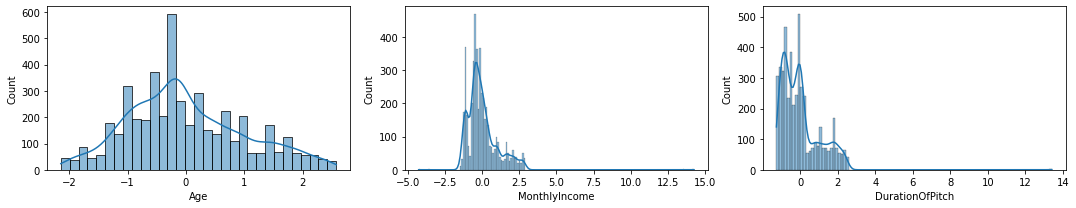

In [41]:
# now let's check histogram againfor those cols

ncols = 3; nrows = 1
fig, ax = plt.subplots(ncols = ncols, nrows =nrows, figsize = (15,3))

for ind, x in enumerate(cols):
        sns.histplot(x = x, data = df, kde = True, ax = ax[ind] )
        
plt.tight_layout()
plt.show()

In [42]:
# As found out in EDA Section, ProductPitched and Designationn have exactly similar kind of relationshiop w.r.t to the 
# dependent variable, so we will drop one column (Designation)
df.drop(['Designation'], axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4747 entries, 0 to 4887
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProdTaken                 4747 non-null   int64  
 1   Age                       4747 non-null   float64
 2   TypeofContact             4747 non-null   object 
 3   CityTier                  4747 non-null   int64  
 4   DurationOfPitch           4747 non-null   float64
 5   Occupation                4747 non-null   object 
 6   Gender                    4747 non-null   object 
 7   NumberOfPersonVisiting    4747 non-null   int64  
 8   NumberOfFollowups         4747 non-null   float64
 9   ProductPitched            4747 non-null   object 
 10  PreferredPropertyStar     4747 non-null   float64
 11  MaritalStatus             4747 non-null   object 
 12  NumberOfTrips             4747 non-null   float64
 13  Passport                  4747 non-null   int64  
 14  PitchSat

In [43]:
# Let's apply One hot encoding to ['TypeofContact' , 'Occupation', 'Gender', 'ProductPitched' , 'MaritalStatus', 'Passport', 'OwnCar']
# But before applying one hot encoding, lets convert them to categorical types
to_cat = ['TypeofContact' , 'Occupation', 'Gender', 'ProductPitched' , 'MaritalStatus', 'Passport', 'OwnCar']
for i in to_cat:
    df[i] = df[i].astype('category')

In [44]:
# now apply one hot encoding using pandas's method
df = pd.get_dummies(df, columns =to_cat)

In [45]:
# check we're ready for data splitting, 
# all cols are numerical type
# no null-or missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4747 entries, 0 to 4887
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ProdTaken                      4747 non-null   int64  
 1   Age                            4747 non-null   float64
 2   CityTier                       4747 non-null   int64  
 3   DurationOfPitch                4747 non-null   float64
 4   NumberOfPersonVisiting         4747 non-null   int64  
 5   NumberOfFollowups              4747 non-null   float64
 6   PreferredPropertyStar          4747 non-null   float64
 7   NumberOfTrips                  4747 non-null   float64
 8   PitchSatisfactionScore         4747 non-null   int64  
 9   NumberOfChildrenVisiting       4747 non-null   float64
 10  MonthlyIncome                  4747 non-null   float64
 11  TypeofContact_Company Invited  4747 non-null   uint8  
 12  TypeofContact_Self Enquiry     4747 non-null   u

In [46]:
missing_values(df)

,column_name,missing,percent_missing
0,ProdTaken,0,0.0
1,Age,0,0.0
2,CityTier,0,0.0
3,DurationOfPitch,0,0.0
4,NumberOfPersonVisiting,0,0.0
5,NumberOfFollowups,0,0.0
6,PreferredPropertyStar,0,0.0
7,NumberOfTrips,0,0.0
8,PitchSatisfactionScore,0,0.0
9,NumberOfChildrenVisiting,0,0.0


# Split Data

In [47]:
X = df.drop('ProdTaken',axis=1)     
y = df['ProdTaken']   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# 4.0 Model building - Bagging
- 4.1 BaggingClassifier with Default Parameters
- 4.2 RandomForest Classifier with Default Parameters
- 4.3 DecisionTree Classifier with Default Parameters
- 4.4 Model Performance Evaluation - Bagging

In [48]:
## let's first create functions to measure performance of classification models
## Function to create confusion matrix
def conf_mat(model, X_test, y_test):
    
    pred_test =  model.predict(X_test)
    cf = confusion_matrix(y_test, pred_test)
    categories = ['Zero', 'One']
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,6))
    sns.heatmap(cf, annot=labels, fmt=''
            ,xticklabels = categories
            ,yticklabels = categories
            ,cmap='Blues' 
           )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

###  Function to calculate different metric scores of the model - Accuracy, Recall f1 score, and Precision
def metrics_score(model,flag=True):
 
    # defining an empty list to store train and test results
    score_list=[] 
    
    #Predicting on train and tests
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    #Accuracy of the model
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    #Recall of the model
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    ##f1_score of the model
    train_f1score = metrics.f1_score(y_train,pred_train)
    test_f1score = metrics.f1_score(y_test,pred_test)
    
    #Precision of the model
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
        print("f1_score on training set : ",metrics.f1_score(y_train,pred_train))
        print("f1_score on test set : ",metrics.f1_score(y_test,pred_test))
    
    
    return score_list # returning the list with train and test scores

def show_feature_importance(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    feature_names = list(X.columns)

    plt.figure(figsize=(12,12))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [49]:
# Default Bagging Classifier
#base_estimator for bagging classifier is a decision tree by default
bagging_d=BaggingClassifier(random_state=1)
bagging_d.fit(X_train,y_train)

BaggingClassifier(random_state=1)

Accuracy on training set :  0.9942805538832029
Accuracy on test set :  0.8947368421052632
Recall on training set :  0.9712460063897763
Recall on test set :  0.6007462686567164
Precision on training set :  0.9983579638752053
Precision on test set :  0.7892156862745098
f1_score on training set :  0.9846153846153846
f1_score on test set :  0.6822033898305085


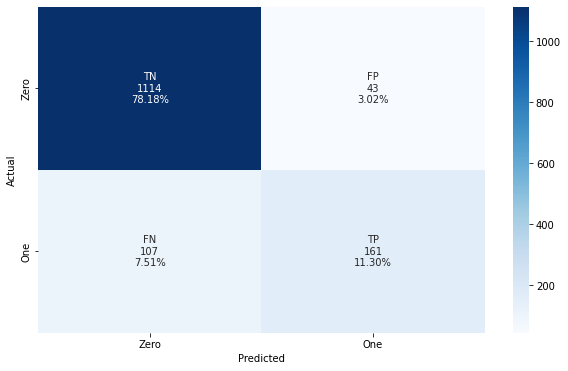

In [50]:
metrics_score(bagging_d)
conf_mat(bagging_d, X_test, y_test)


## Metrics to be used in this case
- Since this is a classification case, where the idea is to classify whether a customer will take a Product or Not, we propose
to maximize TP while minimizing FN. 
- Hence Recall is the preferred KPI with good Accuracy

In [51]:
# Default Random Forest Classifier
rf_d=RandomForestClassifier(random_state=1)
rf_d.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

Accuracy on training set :  1.0
Accuracy on test set :  0.9059649122807018
Recall on training set :  1.0
Recall on test set :  0.5671641791044776
Precision on training set :  1.0
Precision on test set :  0.8941176470588236
f1_score on training set :  1.0
f1_score on test set :  0.6940639269406393


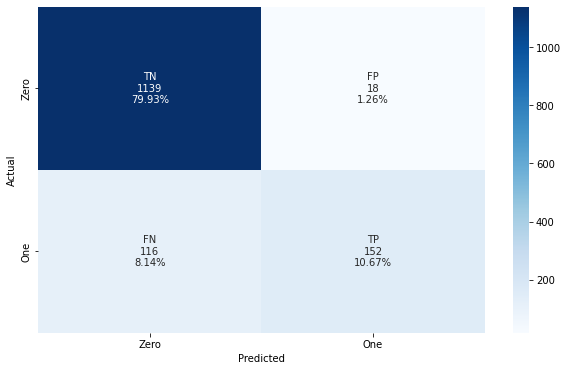

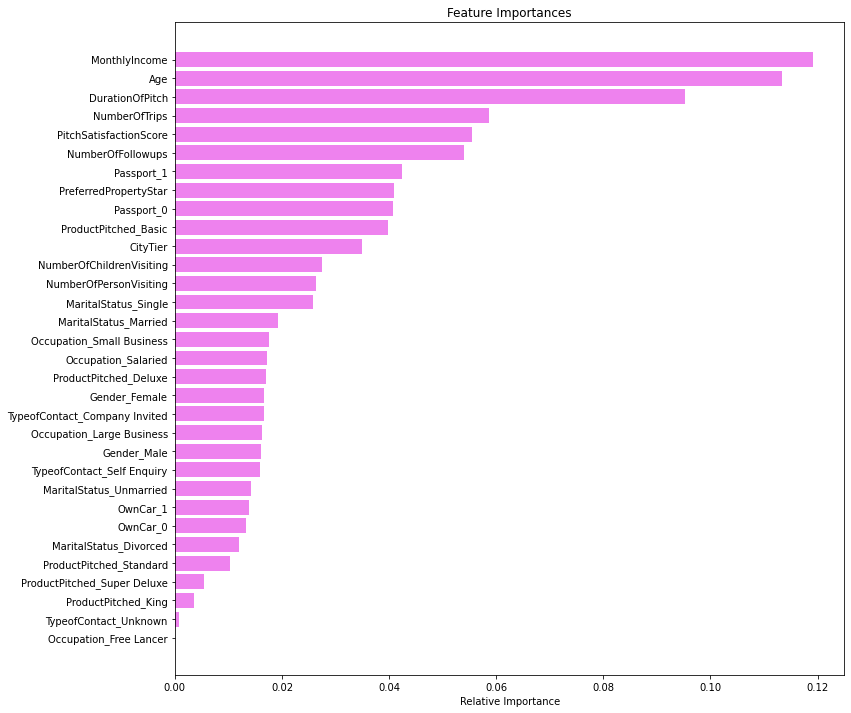

In [52]:
metrics_score(rf_d)
conf_mat(rf_d, X_test, y_test)
show_feature_importance(rf_d)

In [53]:
# Default Decision Tree
# 1. Initial Decision Tree Model (without any hyperparameter)
# create and fit the model to train
# in bid to produce the best outcome, this will generally produce a highly complex tree and overfitted model
dTree_d = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree_d.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

Accuracy on training set :  1.0
Accuracy on test set :  0.8842105263157894
Recall on training set :  1.0
Recall on test set :  0.7425373134328358
Precision on training set :  1.0
Precision on test set :  0.6745762711864407
f1_score on training set :  1.0
f1_score on test set :  0.7069271758436945


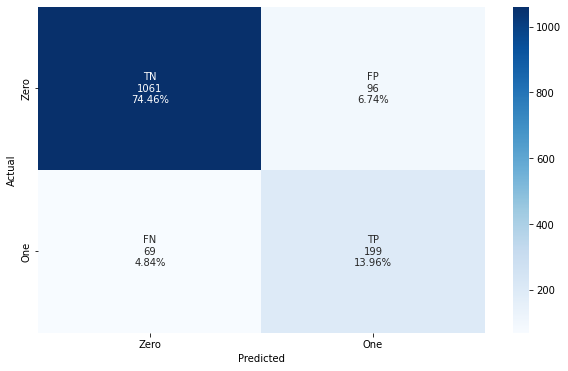

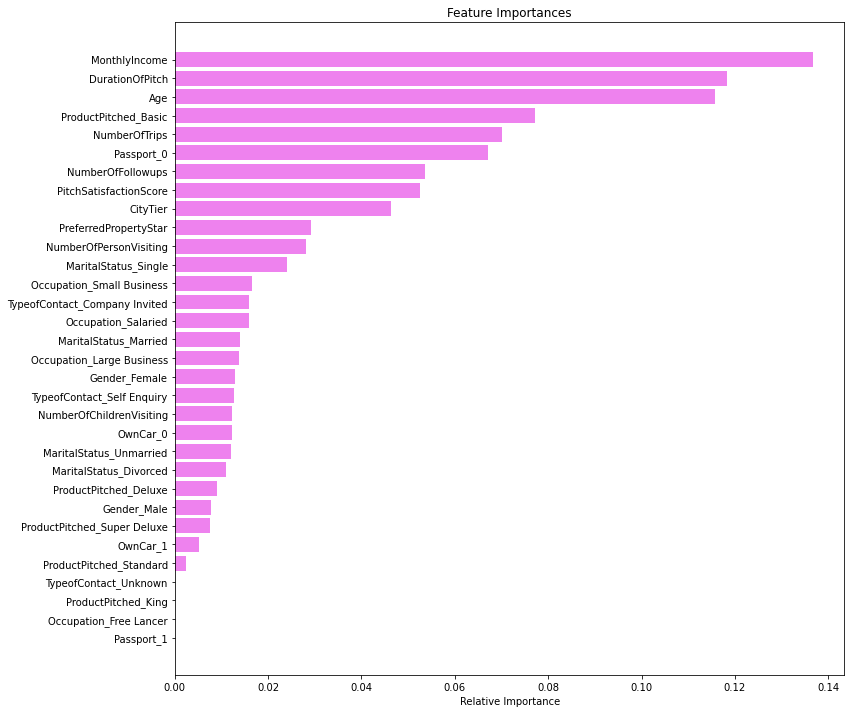

In [54]:
metrics_score(dTree_d)
conf_mat(dTree_d, X_test, y_test)
show_feature_importance(dTree_d)

# 5.0 Model building - Bagging with Hyperparameters
- 5.1 BaggingClassifier with HyperParameters
- 5.2 RandomForest Classifier with HyperParameters
- 5.3 DecisionTree Classifier with HyperParameters
- 5.4 Model Performance Evaluation - Bagging with Hyperparameters


In [56]:
# Bagging Classifier with Hyperparameters
bagging_estimator_tuned = BaggingClassifier(random_state=1, n_jobs = -1)

# Grid of parameters to choose from
## add from article
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [25,50,75,100],
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_h = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_h.fit(X_train, y_train)

BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=25, n_jobs=-1,
                  random_state=1)

Accuracy on training set :  0.9981938591210114
Accuracy on test set :  0.9059649122807018
Recall on training set :  0.9904153354632588
Recall on test set :  0.6380597014925373
Precision on training set :  1.0
Precision on test set :  0.8221153846153846
f1_score on training set :  0.9951845906902087
f1_score on test set :  0.7184873949579832


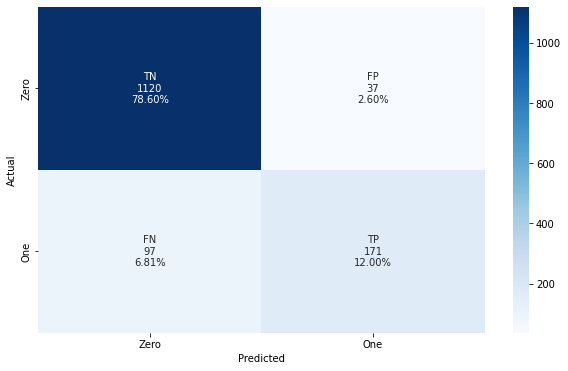

In [57]:
metrics_score(bagging_h)
conf_mat(bagging_h, X_test, y_test)


In [58]:
# RandomforestClassifier with Hyperparameters
rf_estimator_tuned = RandomForestClassifier(random_state=1, n_jobs = -1)

# Grid of parameters to choose from
## add from article
parameters = {"n_estimators": [150,200,250],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1),
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_h = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_h.fit(X_train, y_train)

RandomForestClassifier(max_features=0.6000000000000001,
                       max_samples=0.6000000000000001, min_samples_leaf=5,
                       n_estimators=200, n_jobs=-1, random_state=1)

Accuracy on training set :  0.9145093317278747
Accuracy on test set :  0.863859649122807
Recall on training set :  0.5830670926517572
Recall on test set :  0.40671641791044777
Precision on training set :  0.9407216494845361
Precision on test set :  0.7569444444444444
f1_score on training set :  0.719921104536489
f1_score on test set :  0.5291262135922331


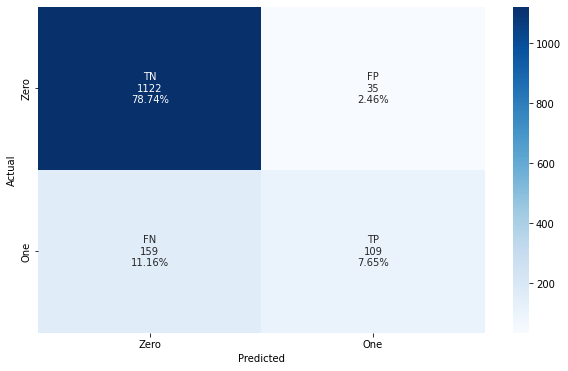

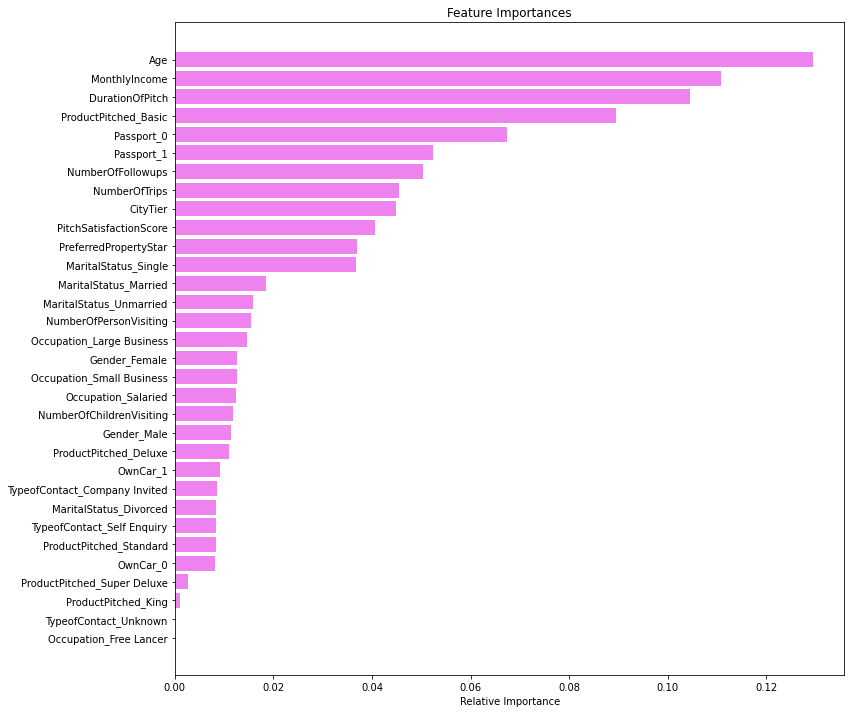

In [59]:
metrics_score(rf_h)
conf_mat(rf_h, X_test, y_test)
show_feature_importance(rf_h)

In [60]:
# DecisionTree Classifier with Hyperparameters (pre-pruning)

from sklearn.model_selection import GridSearchCV
estimator = DecisionTreeClassifier(random_state=1)

parameters = {'max_depth': np.arange(1,10), 
              'min_samples_leaf': [1, 2, 5, 7, 10,15,20],
              'max_leaf_nodes' : [2, 3, 5, 10, 15, 20],
              'min_impurity_decrease': [0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(recall_score)  # we can use recall score here generally for comparision between models rather than accuracy

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dTree_h = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dTree_h.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=15,
                       min_impurity_decrease=0.001, min_samples_leaf=10,
                       random_state=1)

Accuracy on training set :  0.8437688139674895
Accuracy on test set :  0.8287719298245614
Recall on training set :  0.476038338658147
Recall on test set :  0.4253731343283582
Precision on training set :  0.6094069529652352
Precision on test set :  0.5588235294117647
f1_score on training set :  0.5345291479820627
f1_score on test set :  0.48305084745762716


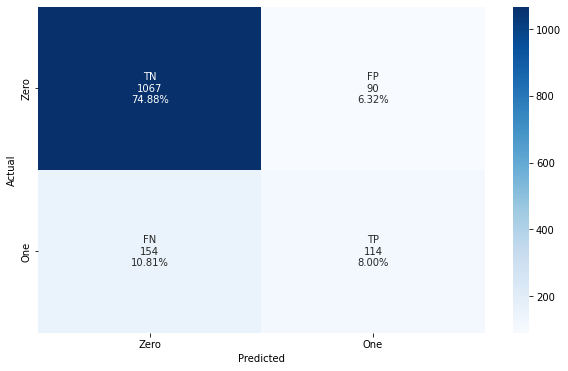

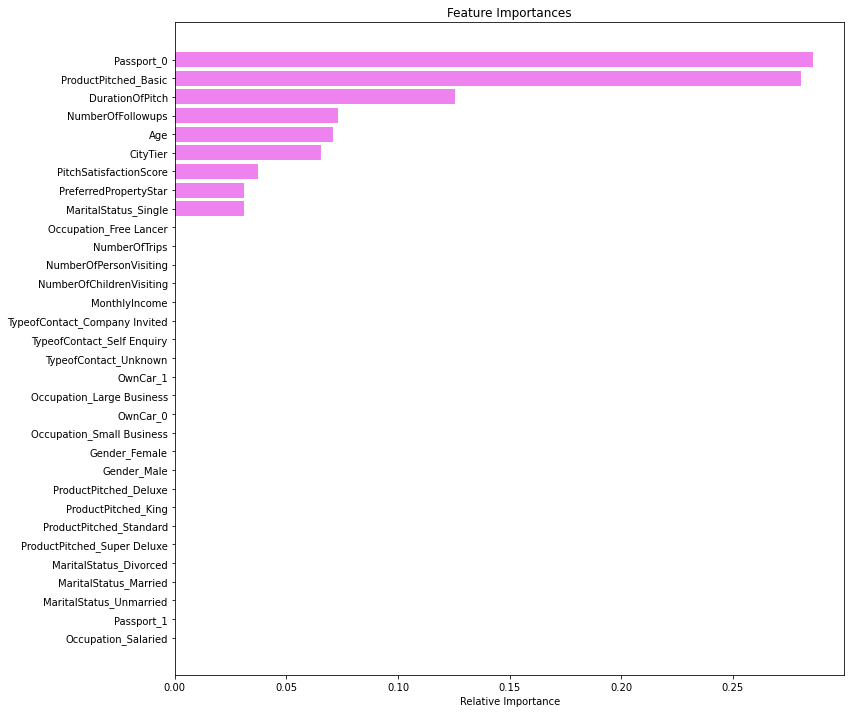

In [61]:
metrics_score(dTree_h)
conf_mat(dTree_h, X_test, y_test)
show_feature_importance(dTree_h)

In [63]:
# defining list of models
models = [bagging_d, rf_d, dTree_d, bagging_h, rf_h, dTree_h]
          

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the accuracy, precall and precision scores
for model in models:
    j = metrics_score(model,False)
    acc_train.append(np.round(j[0],2))
    acc_test.append(np.round(j[1],2))
    recall_train.append(np.round(j[2],2))
    recall_test.append(np.round(j[3],2))
    precision_train.append(np.round(j[4],2))
    precision_test.append(np.round(j[5],2))

In [65]:
comparison_frame = pd.DataFrame({'Model':['Default Bagging Classifier','Default Random Forest Classifier',
                                        'Default Decision Tree',
                                    
                                         'Bagging with Hyperparameters',
                                         'Randomforest with Hyperparameters',
                                         'DecisionTree with Hyperparameters'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test}) 
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Default Bagging Classifier,0.99,0.89,0.97,0.60,1.00,0.79
1,Default Random Forest Classifier,1.00,0.91,1.00,0.57,1.00,0.89
2,Default Decision Tree,1.00,0.88,1.00,0.74,1.00,0.67
3,Bagging with Hyperparameters,1.00,0.91,0.99,0.64,1.00,0.82
4,Randomforest with Hyperparameters,0.91,0.86,0.58,0.41,0.94,0.76
5,DecisionTree with Hyperparameters,0.84,0.83,0.48,0.43,0.61,0.56


## Observations from Bagging Classifier (both default and with Hyperparameters)
- All models, except Decision Tree with Hyperparameters, either overfit or have very poor score on recall on Test data
- The Model, Decisiontree with Hyperparameters, is the best in this lot
    - However, the recall score is still very poor for this model to be used


# 6.0 Model building - Boosting
- 6.1 AdaBoost with Default Parameters
- 6.2 Gradient Boost with Default Parameters
- 6.3 XGBoost with Default Parameters
- 6.4 StackingClassifier with Default Parameters
- 6.5 Model Performance Evaluation - Boosting

In [66]:
# AdaBoost with Default Parameter
abc_d = AdaBoostClassifier(random_state=1)
abc_d.fit(X_train,y_train)

AdaBoostClassifier(random_state=1)

Accuracy on training set :  0.8482841661649608
Accuracy on test set :  0.8428070175438597
Recall on training set :  0.35303514376996803
Recall on test set :  0.31343283582089554
Precision on training set :  0.690625
Precision on test set :  0.6774193548387096
f1_score on training set :  0.4672304439746301
f1_score on test set :  0.4285714285714286


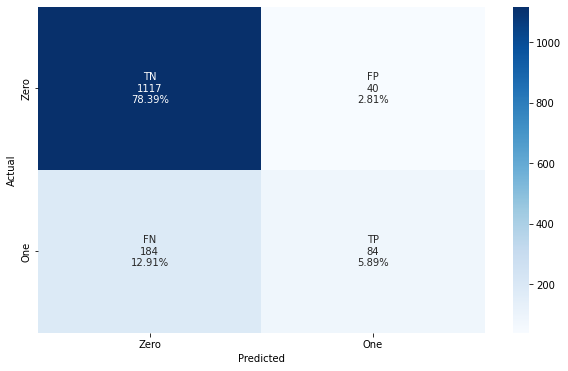

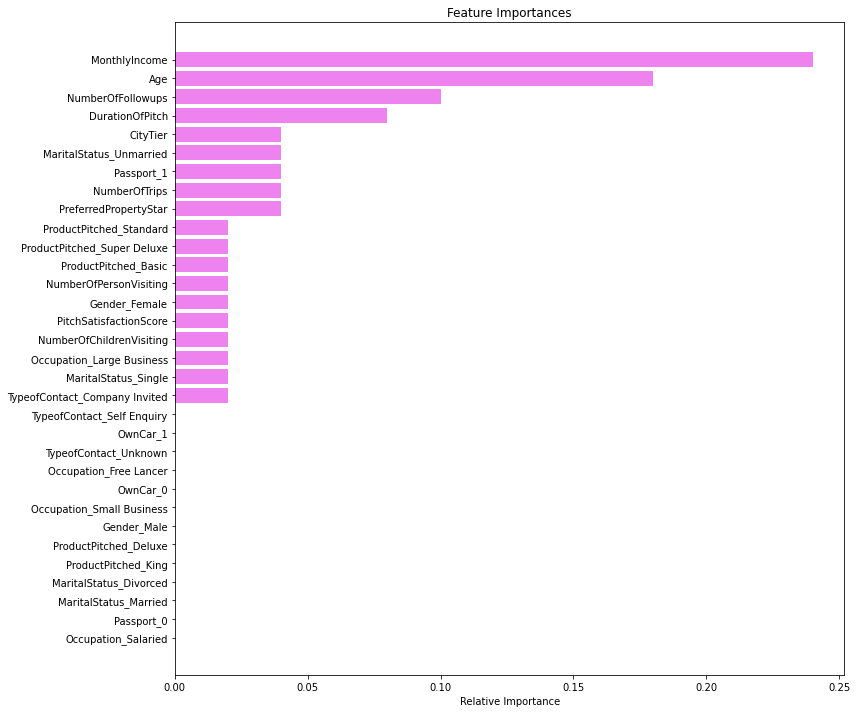

In [67]:
metrics_score(abc_d)
conf_mat(abc_d, X_test, y_test)
show_feature_importance(abc_d)

In [68]:
# GradientBoost with Default Parameter
gbc_d = GradientBoostingClassifier(random_state=1)
gbc_d.fit(X_train,y_train)

GradientBoostingClassifier(random_state=1)

Accuracy on training set :  0.8940397350993378
Accuracy on test set :  0.8610526315789474
Recall on training set :  0.5095846645367412
Recall on test set :  0.39925373134328357
Precision on training set :  0.8763736263736264
Precision on test set :  0.7430555555555556
f1_score on training set :  0.6444444444444444
f1_score on test set :  0.5194174757281553


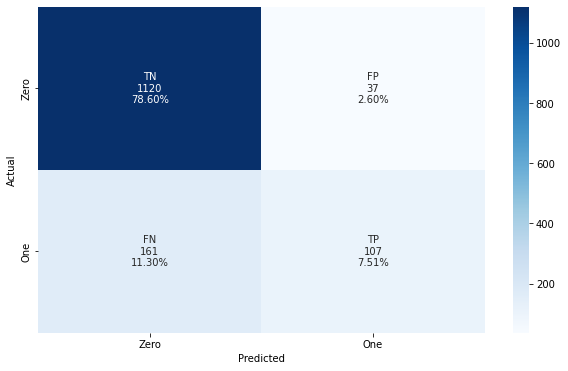

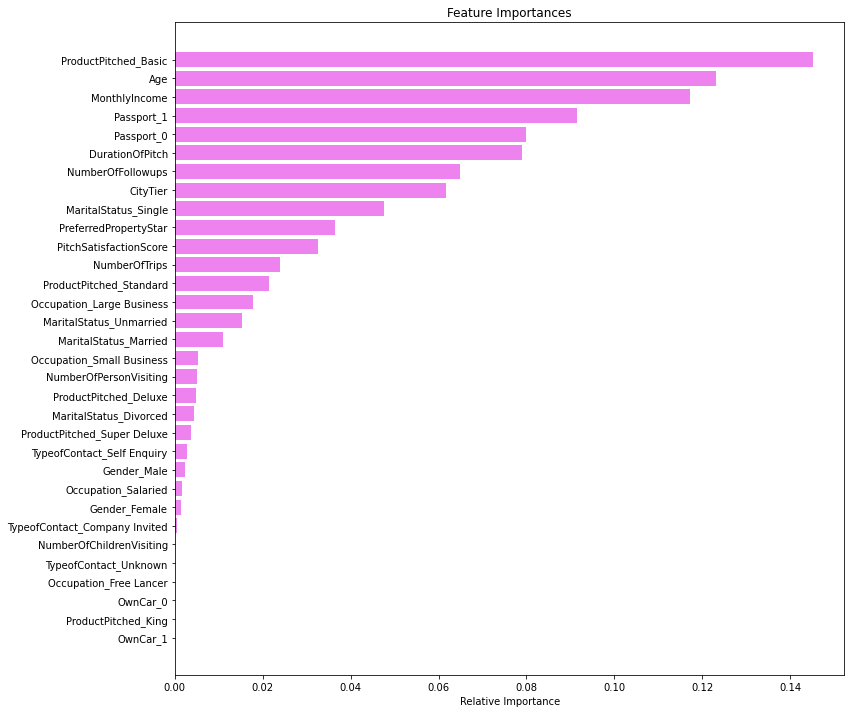

In [69]:
metrics_score(gbc_d)
conf_mat(gbc_d, X_test, y_test)
show_feature_importance(gbc_d)

In [70]:
#XGBoost with Default Parameters
xgb_d = XGBClassifier(random_state=1,eval_metric='logloss')
xgb_d.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Accuracy on training set :  0.9996989765201686
Accuracy on test set :  0.9192982456140351
Recall on training set :  0.9984025559105432
Recall on test set :  0.6716417910447762
Precision on training set :  1.0
Precision on test set :  0.8695652173913043
f1_score on training set :  0.9992006394884093
f1_score on test set :  0.7578947368421053


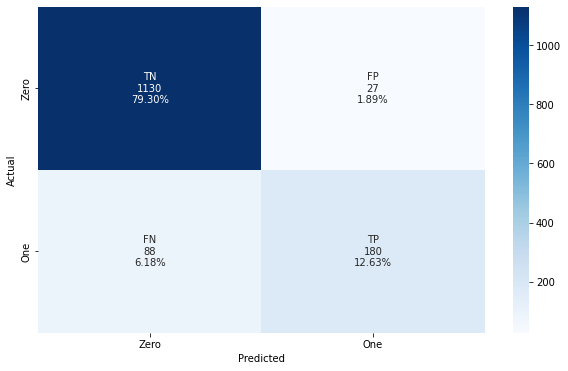

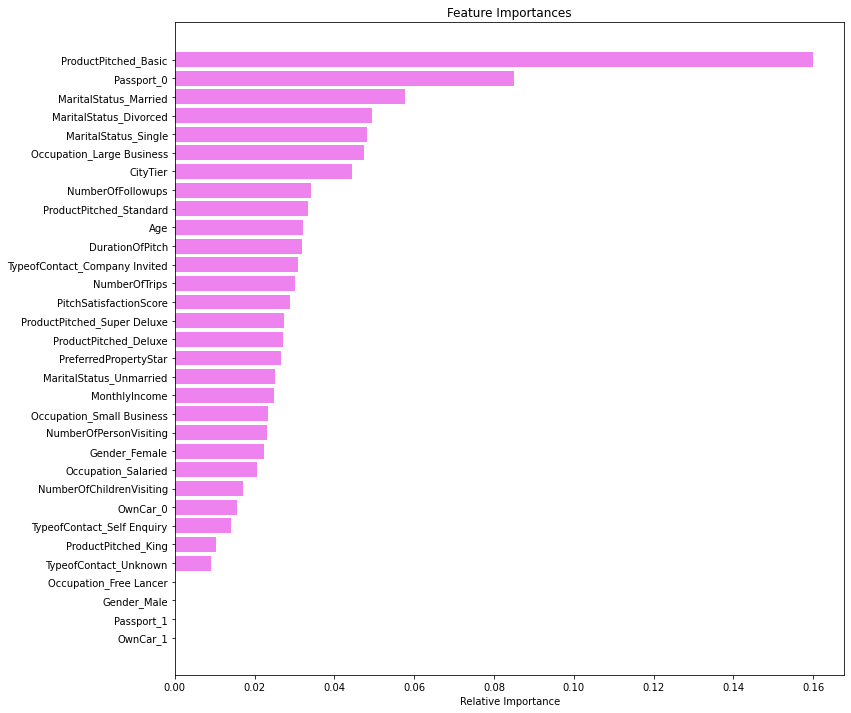

In [71]:
metrics_score(xgb_d)
conf_mat(xgb_d, X_test, y_test)
show_feature_importance(xgb_d)

In [72]:
# Stacking Classifier with ADABoost & GradientBoost as classifiers and XGBoost as Meta Classifier
AD = AdaBoostClassifier(random_state=1)
GB = GradientBoostingClassifier(random_state=1)
XG = XGBClassifier(random_state=1,eval_metric='logloss')  # defining meta-classifier
clf_stack2 = StackingClassifier(classifiers =[AD, GB], meta_classifier = XG, use_probas = True, use_features_in_secondary = True)
clf_stack2.fit(X_train, y_train)

StackingClassifier(classifiers=[AdaBoostClassifier(random_state=1),
                                GradientBoostingClassifier(random_state=1)],
                   meta_classifier=XGBClassifier(base_score=None, booster=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 enable_categorical=False,
                                                 eval_metric='logloss',
                                                 gamma=None, gpu_id=None,
                                                 importance_type=None,
                                                 interaction_constraint...
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 min_chi

Accuracy on training set :  1.0
Accuracy on test set :  0.9066666666666666
Recall on training set :  1.0
Recall on test set :  0.7014925373134329
Precision on training set :  1.0
Precision on test set :  0.7800829875518672
f1_score on training set :  1.0
f1_score on test set :  0.7387033398821219


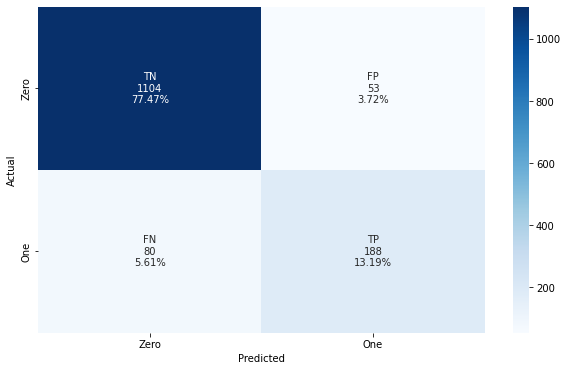

In [73]:
metrics_score(clf_stack2)
conf_mat(clf_stack2, X_test, y_test)

# 7.0 Model Building - Boosting with Hyperparameters
- 7.1 Adaboost with Hyperparameters
- 7.2 Gradientboost with Hyperparameters
- 7.3 XGBOost with Hyperparameters
- 7.4 Model Performance Evaluation - Boosting with Hyperparameters

In [74]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    "base_estimator":[DecisionTreeClassifier(max_depth=1, random_state=1),DecisionTreeClassifier(max_depth=2, random_state=1),DecisionTreeClassifier(max_depth=3, random_state=1)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=1.7000000000000002, n_estimators=100,
                   random_state=1)

Accuracy on training set :  0.9819385912101144
Accuracy on test set :  0.8708771929824561
Recall on training set :  0.9329073482428115
Recall on test set :  0.5746268656716418
Precision on training set :  0.9700996677740864
Precision on test set :  0.6875
f1_score on training set :  0.9511400651465798
f1_score on test set :  0.6260162601626017


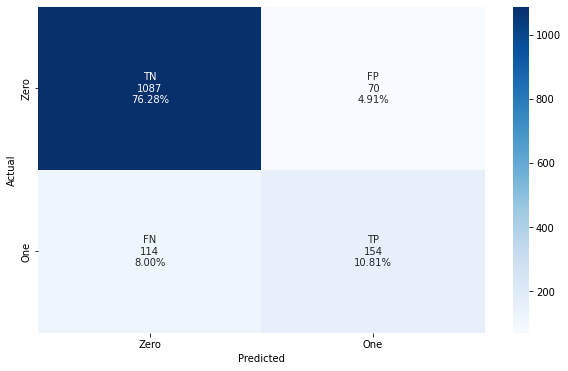

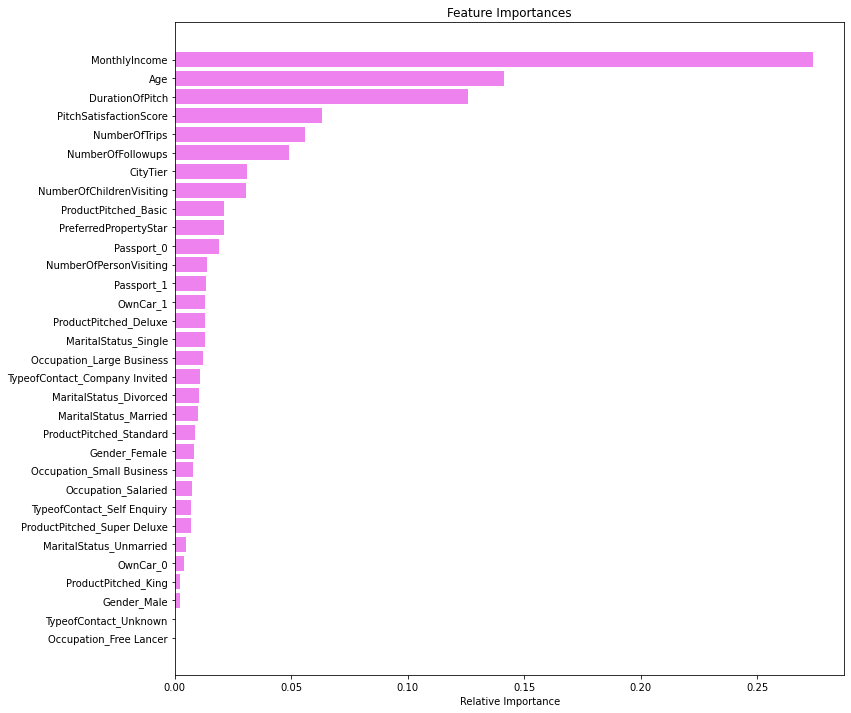

In [75]:
metrics_score(abc_tuned)
conf_mat(abc_tuned, X_test, y_test)
show_feature_importance(abc_tuned)

In [76]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           max_features=0.9, n_estimators=250, random_state=1,
                           subsample=0.8)

Accuracy on training set :  0.9819385912101144
Accuracy on test set :  0.8708771929824561
Recall on training set :  0.9329073482428115
Recall on test set :  0.5746268656716418
Precision on training set :  0.9700996677740864
Precision on test set :  0.6875
f1_score on training set :  0.9511400651465798
f1_score on test set :  0.6260162601626017


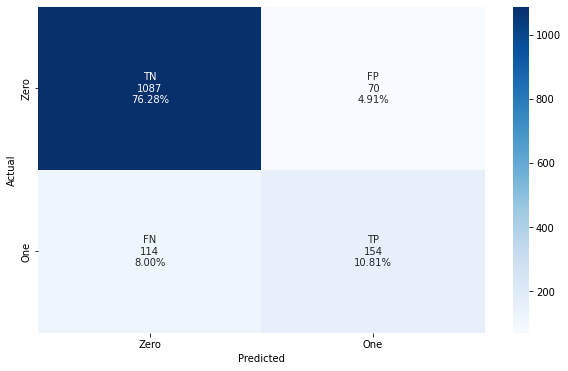

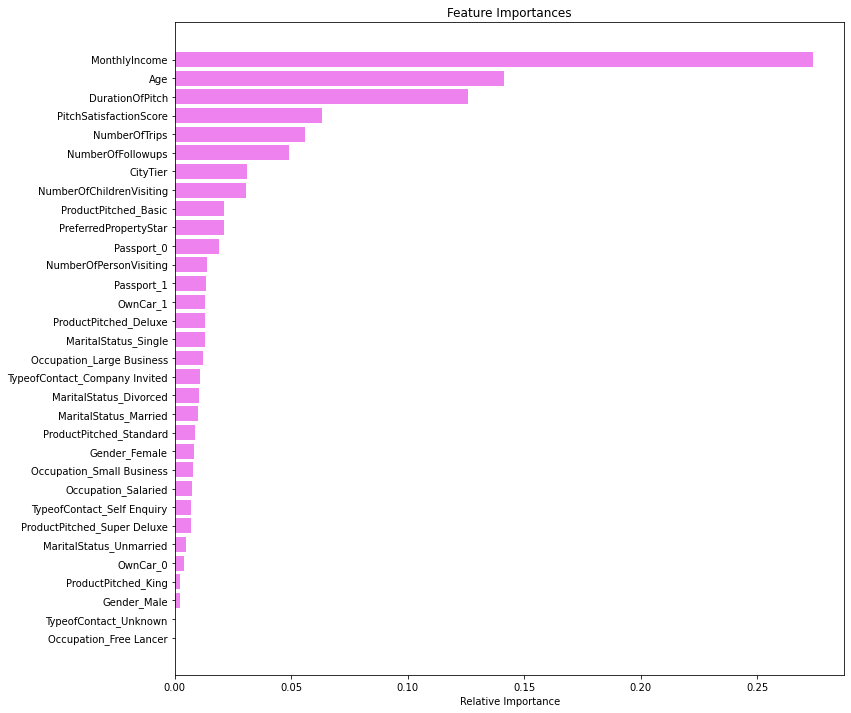

In [77]:
metrics_score(abc_tuned)
conf_mat(abc_tuned, X_test, y_test)
show_feature_importance(abc_tuned)

In [78]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1,eval_metric='logloss', n_jobs = -1)

# Grid of parameters to choose from
## add from
parameters = {
    "n_estimators": np.arange(10,100,20),
    "scale_pos_weight":[0,1,2,5],
    "subsample":[0.5,0.7,0.9,1],
    "learning_rate":[0.01,0.1,0.2,0.05],
    "gamma":[0,1,3],
    "colsample_bytree":[0.5,0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='logloss', gamma=1,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=30, n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=5,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Accuracy on training set :  0.9069837447320891
Accuracy on test set :  0.8456140350877193
Recall on training set :  0.9153354632587859
Recall on test set :  0.7649253731343284
Precision on training set :  0.6911942098914354
Precision on test set :  0.5662983425414365
f1_score on training set :  0.7876288659793814
f1_score on test set :  0.6507936507936509


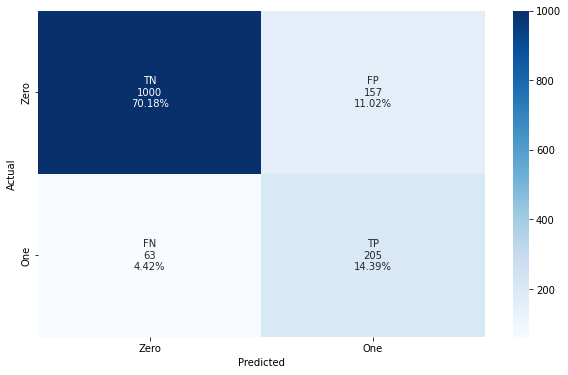

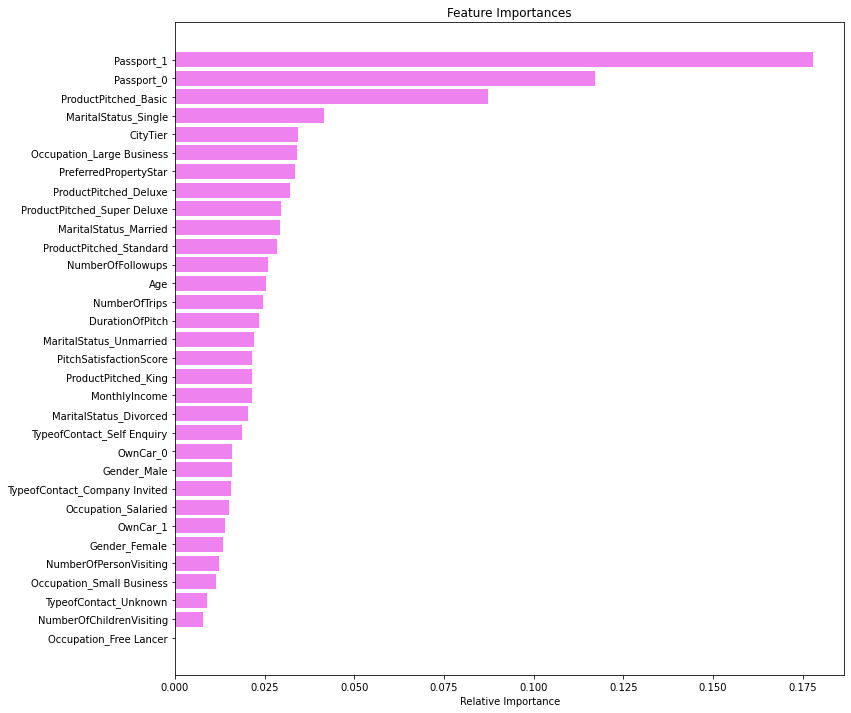

In [79]:
metrics_score(xgb_tuned)
conf_mat(xgb_tuned, X_test, y_test)
show_feature_importance(xgb_tuned)

In [80]:
# defining list of models for Boosting Classifiers
models = [abc_d, gbc_d, xgb_d, clf_stack2, abc_tuned, gbc_tuned, xgb_tuned]
          

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the accuracy, precall and precision scores
for model in models:
    j = metrics_score(model,False)
    acc_train.append(np.round(j[0],2))
    acc_test.append(np.round(j[1],2))
    recall_train.append(np.round(j[2],2))
    recall_test.append(np.round(j[3],2))
    precision_train.append(np.round(j[4],2))
    precision_test.append(np.round(j[5],2))

In [82]:
# model performance comparision for Boosting Classifier
comparison_frame_1 = pd.DataFrame({'Model':['Default AdaBoost Classifier','Default GradientBoost Classifier',
                                        
                                         'Default XGBoost Classifier',
                                         'Default StackingClassifier', 
                                         'AdaBoost with Hyperparameters',
                                         'GradientBoost with Hyperparameters',
                                         'XGBoost with Hyperparameters'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test}) 
comparison_frame_1

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Default AdaBoost Classifier,0.85,0.84,0.35,0.31,0.69,0.68
1,Default GradientBoost Classifier,0.89,0.86,0.51,0.40,0.88,0.74
2,Default XGBoost Classifier,1.00,0.92,1.00,0.67,1.00,0.87
3,Default StackingClassifier,1.00,0.91,1.00,0.70,1.00,0.78
4,AdaBoost with Hyperparameters,0.98,0.87,0.93,0.57,0.97,0.69
5,GradientBoost with Hyperparameters,0.93,0.88,0.65,0.51,0.93,0.77
6,XGBoost with Hyperparameters,0.91,0.85,0.92,0.76,0.69,0.57


## Observations from Boosting Classifier (both default and with Hyperparameters)
- All models, except XGBoost with Hyperparameters, either overfit or have very poor score on recall on Test data
- The Model, XGBoost with Hyperparameters, is the best that we've seen so far
    - not overfitting too much(may be slightly)
    - best recall score on out-of-sample data so far

# 8.0 Actionable Insights & Recommendations

## Comparing Performance for all Models

In [89]:
comparison_frame_final = pd.concat([comparison_frame,comparison_frame_1], axis = 0).reset_index(drop = True)
comparison_frame_final

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Default Bagging Classifier,0.99,0.89,0.97,0.60,1.00,0.79
1,Default Random Forest Classifier,1.00,0.91,1.00,0.57,1.00,0.89
2,Default Decision Tree,1.00,0.88,1.00,0.74,1.00,0.67
3,Bagging with Hyperparameters,1.00,0.91,0.99,0.64,1.00,0.82
4,Randomforest with Hyperparameters,0.91,0.86,0.58,0.41,0.94,0.76
5,DecisionTree with Hyperparameters,0.84,0.83,0.48,0.43,0.61,0.56
6,Default AdaBoost Classifier,0.85,0.84,0.35,0.31,0.69,0.68
7,Default GradientBoost Classifier,0.89,0.86,0.51,0.40,0.88,0.74
8,Default XGBoost Classifier,1.00,0.92,1.00,0.67,1.00,0.87
9,Default StackingClassifier,1.00,0.91,1.00,0.70,1.00,0.78


## Model Selection
- As seen from the above dataframe, most of the models either overfit or have a very poor scores on Test
- The Model, XGBoost with Hyperparameters, is selected for this case. It the best model so far with 0.76 recall and 0.85 accuracy on out-of sampe data


## Insights and Recommendataions to 'Visit with Us'
From the EDA, some of the identified variables of Customer/ Product profile were Male, City Tier 1, own car, Self Enquiry, younger age, lower median salary, single or married,
Therefore, the recommendation to "Visit with us" is to:
- Generally allow for better facilities for customers to allow self enquiry
- Position "Wellness Package" and market as a wellness & lifestyle based and  suitable product for customers:
    - Tier 1, who own car, are young single or married
- The business should check at the data since there are many variables
- Furthermore, many variables dont seem to have any predicting power at all
- Even the seemingly numerical cols are kind of categorical since they have mostly discrete values 
- Business can model the case in tuned XGBoost Classifier for satisfactory predicting on the dataset that is highly imbalanced
 
